In [1]:
import peres_pyquil as pp
import peres_analysis as pa
import pickle
import numpy as np, matplotlib.pyplot as plt
from collections import Counter
import sys
import time
import multiprocessing as mp
Z_SCORE = 3
N_SHOTS = 10_000
import peres_pyquil_noise_models as ppnm
from scipy.optimize import curve_fit as cf

with open('select_states_aspen_with_cfs', 'rb') as file:
    select_states = pickle.load(file)

q1, q2 = 12, 25
trial = 1
amp_damp = 0.3
deph_damp = 1-0.9820553488690702
pmeas_1 = [0.968, 0.968]
t1 = 4e-6
t2=4.4e-6

pmeas_2 = [0.961, 0.961]

# iters = 1
# states = [{'State_params': pa.params_complex()} for _ in range(iters)]
def fit_F(x, m, c):
    return m*x + c

engine = 'deph-qvm'
try:
    select_states = ppnm.run_peres(q1, q2, trial, engine, select_states, amp_damp, deph_damp, pmeas_1, pmeas_2, t1,t2)
except Exception as e:
    print(e)
    
# engine = 'qvm'
# try:
#     states = pp.run_peres(q1, q2, trial, engine, states)
# except Exception as e:
#     print(e)

# select_states = pa.compute_gammas(select_states, 'Aspen')
select_states = pa.compute_gammas(select_states, 'deph-qvm')

Engine requested: deph-qvm
Running Bell-state measurements
Done with iteration 23

Running Computational measurements
Creating folder product_peres_deph-qvm_2021-07-23_12_25_bits_10000_shots_trial_1
Results saved in file product_peres_deph-qvm_2021-07-23_12_25_bits_10000_shots_trial_1/result_list_trial_1

Completed.


In [2]:
# if __name__ == '__main__':
#     manager = mp.Manager()
#     return_dict = manager.dict()
    
#     procs = [mp.Process(target=get_cfs_boot, args=(select_states[i*6:(i+1)*6],'deph-qvm', return_dict, i)) for i in range(4)]
    
#     for proc in procs:
#         proc.start()
#     for proc in procs:
#         proc.join()
# select_states = [elem for key in range(4) for elem in return_dict[key]]

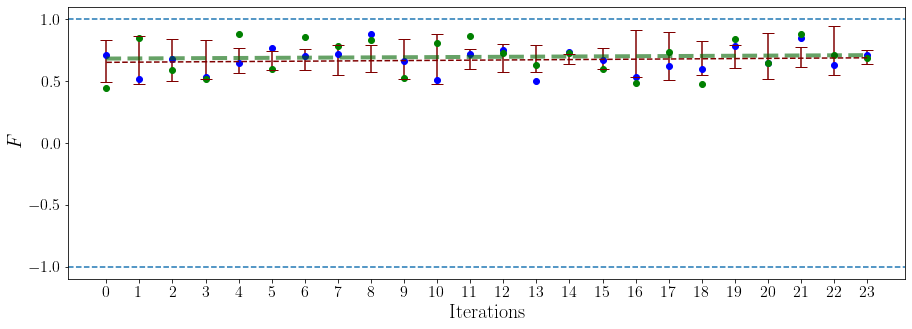

In [3]:
fth = np.array([select_states[i]['Gammas_theory']['F'] for i in range(len(select_states))])
errth = np.array([select_states[i]['cfs_theory']['F'] for i in range(len(select_states))])

f2q = [select_states[i]['Gamma_2q-qvm']['F'] for i in range(len(select_states))]

fas = np.array([select_states[i]['Gamma_Aspen']['F'] for i in range(len(select_states))])
erras = np.array([select_states[i]['cfs_Aspen']['F'] for i in range(len(select_states))])

fnq = np.array([select_states[i]['Gamma_deph-qvm']['F'] for i in range(len(select_states))])
# errnq = np.array([select_states[i]['cfs_deph-qvm']['F'] for i in range(len(select_states))])


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})
fig = plt.figure(figsize=(15,5))
# plt.subplot(2,2,4)
# plt.errorbar(range(len(fnq)), fnq, yerr=[fnq - errnq[:,0], errnq[:,1] - fnq], ls='', marker = 'D', capsize=6, color='maroon', alpha=1, lw=1)
# plt.errorbar(range(len(fas)), fas, yerr=[fas - erras[:,0], erras[:,1] - fas], ls='', marker = 'o', capsize=6, color='darkgreen', alpha=1, lw=1)
# plt.errorbar(range(len(fth)), fth, yerr=[fth - errth[:,0], errth[:,1] - fth], ls='', marker = '', capsize=6, color='blue', alpha=1, lw=1)
plt.plot(fnq, 'o', color='blue')
plt.plot(fas, 'o', color='green')

plt.xticks(range(len(select_states)))
plt.axhline(y=-1, ls='dashed')
plt.axhline(y=1, ls='dashed')

x = np.arange(len(fas))
popt, pcov = cf(fit_F, x, fas)
plt.plot(x, fit_F(x, *popt), ls='dashed', color='darkgreen', alpha=0.6, lw=4)

popt, pcov = cf(fit_F, x, fnq)
# plt.plot(x, fit_F(x, *popt), ls='dashed', color='maroon', alpha=1)
plt.errorbar(x, fit_F(x, *popt), yerr=[fth - errth[:,0], errth[:,1] - fth], ls='dashed', color='maroon', alpha=1, capsize=6)

plt.xlabel('Iterations', size=20)
plt.ylabel('$F$', size=20)
plt.xticks(size=16)
plt.yticks(list(np.arange(-1,1.1, 0.5)),size=16)

plt.savefig('error_compensated.pdf', bbox_inches='tight')
plt.show()

In [4]:
with open('results_aspen_theory_noisy_aspen9_errors.pkl', 'wb') as file:
    pickle.dump(select_states, file)

In [144]:
popt

array([0.00132895, 0.6779948 ])

In [27]:
# with open('select_states_aspen_with_cfs_good_fit_2', 'wb') as file:
#     pickle.dump(select_states, file)

In [162]:
with open('select_states_aspen_with_cfs', 'rb') as file:
    test = pickle.load(file)

# Initial analysis

In [112]:
select_states = pa.compute_gammas(states, '2q-qvm')
# states = pa.compute_gammas(states, 'qvm')
select_states = pa.compute_gammas(states, 'Aspen')

In [42]:
def get_cfs(result_list, return_dict, proc_no):
    print(f'Started process {proc_no}.')
    st = time.time()
    result_list = pa.get_theory_cfs(result_list)
    return_dict[proc_no] = result_list
    print(f'Finished process {proc_no} in {time.time() - st} secs.')
    return None

def get_cfs_boot(result_list, engine, return_dict, proc_no):
    print(f'Started process {proc_no}.')
    st = time.time()
    result_list = pa.get_cfs_boot(result_list, engine)
    return_dict[proc_no] = result_list
    print(f'Finished process {proc_no} in {time.time() - st} secs.')
    return None

In [84]:
if __name__ == '__main__':
    manager = mp.Manager()
    return_dict = manager.dict()
    
    procs = [mp.Process(target=get_cfs, args=(states[i*6:(i+1)*6],return_dict, i)) for i in range(4)]
    
    for proc in procs:
        proc.start()
    for proc in procs:
        proc.join()
states = [elem for key in return_dict.keys() for elem in return_dict[key]]

Started process 0.Started process 1.

Started process 2.
Started process 3.
Started process 4.
Started process 5.Started process 6.
Started process 7.

Started process 9.
Started process 8.


/home/jovyan/Final Peres codes/peres_analysis.py:78: RuntimeWarning: divide by zero encountered in double_scalars
  counts = binomial_dist(np.array(res['State_params'], dtype=float), 10_000, 10_000)
/home/jovyan/Final Peres codes/peres_analysis.py:78: RuntimeWarning: invalid value encountered in double_scalars
  counts = binomial_dist(np.array(res['State_params'], dtype=float), 10_000, 10_000)


Finished process 4 in 269.2321743965149 secs.
Finished process 0 in 270.27567625045776 secs.
Finished process 9 in 280.4895930290222 secs.
Finished process 5 in 281.71805572509766 secs.
Finished process 8 in 289.7072832584381 secs.
Finished process 1 in 290.08590292930603 secs.
Finished process 3 in 290.597936630249 secs.
Finished process 2 in 292.2922601699829 secs.
Finished process 7 in 294.41766238212585 secs.
Finished process 6 in 296.467732667923 secs.


In [113]:
if __name__ == '__main__':
    manager = mp.Manager()
    return_dict = manager.dict()
    
    procs = [mp.Process(target=get_cfs_boot, args=(select_states[i*6:(i+1)*6],'Aspen', return_dict, i)) for i in range(4)]
    
    for proc in procs:
        proc.start()
    for proc in procs:
        proc.join()
select_states = [elem for key in return_dict.keys() for elem in return_dict[key]]

Started process 0.
Started process 1.
Started process 2.
Started process 3.
Finished process 1 in 994.5425834655762 secs.
Finished process 0 in 1005.1249580383301 secs.
Finished process 3 in 1005.2180616855621 secs.
Finished process 2 in 1006.6124646663666 secs.


In [11]:
with open('select_states.pkl', 'rb') as file:
    select_states = pickle.load(file)

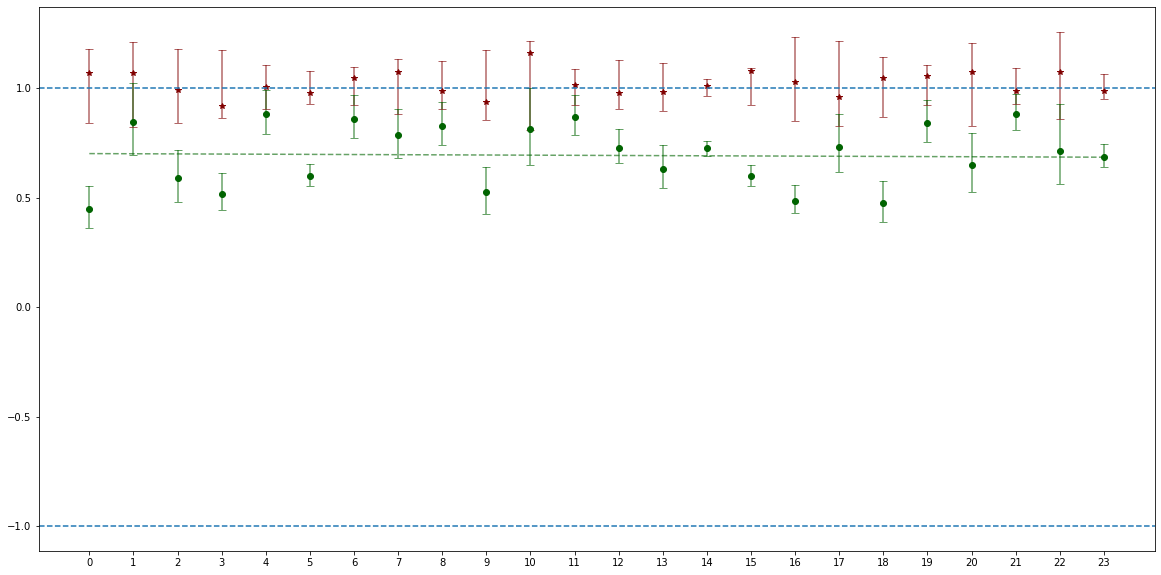

In [115]:
f2q = [select_states[i]['Gamma_2q-qvm']['F'] for i in range(len(select_states))]
err2q = np.array([select_states[i]['cfs_theory']['F'] for i in range(len(select_states))])
fth = np.array([select_states[i]['Gammas_theory']['F'] for i in range(len(select_states))])
fqv = np.array([select_states[i]['Gamma_qvm']['F'] for i in range(len(select_states))])
fas = np.array([select_states[i]['Gamma_Aspen']['F'] for i in range(len(select_states))])
erras = np.array([select_states[i]['cfs_Aspen']['F'] for i in range(len(select_states))])

errqv = np.array([select_states[i]['cfs_qvm']['F'] for i in range(len(select_states))])
fig = plt.figure(figsize=(20,10))
# plt.plot(f2q, 'o')
# plt.plot(fqv, 'o')
plt.errorbar(range(len(fth)), fth, yerr=[fth - err2q[:,0], err2q[:,1] - fth], ls='', marker = '', capsize=4, color='maroon', alpha=0.6)
plt.errorbar(range(len(fas)), fas, yerr=[fas - erras[:,0], erras[:,1] - fas], ls='', marker = '', capsize=4, color='darkgreen', alpha=0.6)
# plt.errorbar(range(len(fqv)), fqv, yerr=[fqv - errqv[:,0], errqv[:,1] - fqv], ls='', marker = 'o', capsize=4)
plt.plot(fas, 'o', color='darkgreen')
plt.plot(f2q, '*', color='maroon')
plt.xticks(range(len(select_states)))
plt.axhline(y=-1, ls='dashed')
plt.axhline(y=1, ls='dashed')

x = np.arange(len(fas))
plt.plot(x, fit_F(x, *popt), ls='dashed', color='darkgreen', alpha=0.6)
plt.show()

In [116]:
popt

array([-0.00071853,  0.702243  ])

In [14]:
engine = 'Aspen'
try:
    select_states = pp.run_peres(q1, q2, trial, engine, select_states)
except Exception as e:
    print(e)

Engine requested: Aspen
Running Bell-state measurements
Done with iteration 23

Running Computational measurements
Creating folder product_peres_Aspen_2021-07-15_12_25_bits_10000_shots_trial_1
Results saved in file product_peres_Aspen_2021-07-15_12_25_bits_10000_shots_trial_1/result_list_trial_1

Completed.


In [31]:
with open('select_states_aspen_with_cfs.pkl', 'wb') as file:
    pickle.dump(select_states, file)

In [21]:
states = pa.compute_gammas(select_states, 'Aspen')

In [142]:
if __name__ == '__main__':
    manager = mp.Manager()
    return_dict = manager.dict()
    
    procs = [mp.Process(target=get_cfs_boot, args=(select_states[i*6:(i+1)*6],'deph-qvm', return_dict, i)) for i in range(4)]
    
    for proc in procs:
        proc.start()
    for proc in procs:
        proc.join()
select_states = [elem for key in range(4) for elem in return_dict[key]]

Started process 0.
Started process 1.
Started process 2.
Started process 3.
Finished process 3 in 585.5125434398651 secs.
Finished process 0 in 592.9913125038147 secs.
Finished process 1 in 594.0771214962006 secs.
Finished process 2 in 597.970950126648 secs.


In [40]:
from scipy.optimize import curve_fit as cf

In [41]:
def fit_F(x, m, c):
    return m*x + c

In [44]:
popt, pcov = cf(fit_F, range(len(fas)), fas)

In [45]:
popt

array([7.43540429e-05, 6.96504667e-01])

In [5]:
with open('select_states_aspen.pkl', 'rb') as file:
    select_states = pickle.load(file)

In [14]:
select_states[0]['Counts_bell_2q-qvm']['a']

{'Clicks': array([[1, 0],
        [1, 0],
        [0, 1],
        ...,
        [1, 0],
        [1, 0],
        [0, 0]]),
 'Counts': Counter({'10': 4416, '01': 2111, '11': 2273, '00': 1200})}

In [15]:
select_states[0]['Counts_bell_Aspen']['a']

{'Clicks': array([[1, 1],
        [1, 0],
        [1, 1],
        ...,
        [1, 1],
        [0, 1],
        [0, 1]]),
 'Counts': Counter({'11': 2115, '10': 4300, '00': 1347, '01': 2238})}

In [69]:
select_states = pa.compute_gammas(select_states, 'Aspen')
select_states = pa.compute_gammas(select_states, 'deph-qvm')

NameError: name 'fit_F' is not defined

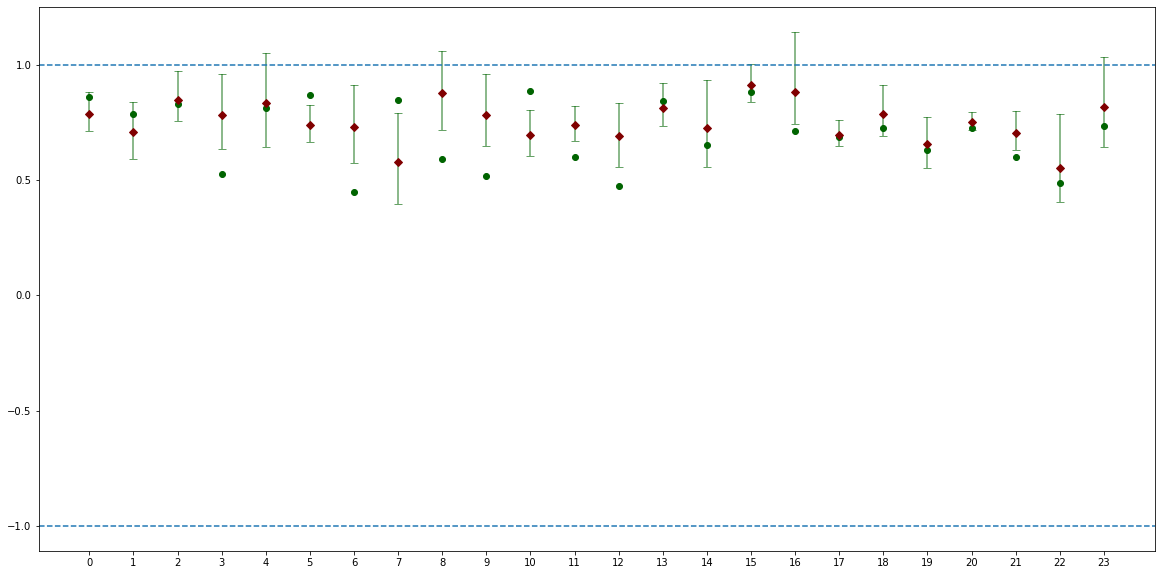

In [70]:
f2q = [select_states[i]['Gamma_2q-qvm']['F'] for i in range(len(select_states))]
err2q = np.array([select_states[i]['cfs_theory']['F'] for i in range(len(select_states))])
fth = np.array([select_states[i]['Gammas_theory']['F'] for i in range(len(select_states))])
fqv = np.array([select_states[i]['Gamma_qvm']['F'] for i in range(len(select_states))])
fas = np.array([select_states[i]['Gamma_Aspen']['F'] for i in range(len(select_states))])
fnq = np.array([select_states[i]['Gamma_deph-qvm']['F'] for i in range(len(select_states))])
# erras = np.array([select_states[i]['cfs_Aspen']['F'] for i in range(len(select_states))])

# errqv = np.array([select_states[i]['cfs_qvm']['F'] for i in range(len(select_states))])
fig = plt.figure(figsize=(20,10))
# plt.plot(f2q, 'o')
# plt.plot(fqv, 'o')
# plt.errorbar(range(len(fth)), fth, yerr=[fth - err2q[:,0], err2q[:,1] - fth], ls='', marker = '', capsize=4, color='maroon', alpha=0.6)
plt.errorbar(range(len(fas)), fnq, yerr=[fth - err2q[:,0], err2q[:,1] - fth], ls='', marker = '', capsize=4, color='darkgreen', alpha=0.6)
# plt.errorbar(range(len(fqv)), fqv, yerr=[fqv - errqv[:,0], errqv[:,1] - fqv], ls='', marker = 'o', capsize=4)
plt.plot(fas, 'o', color='darkgreen')
# plt.plot(f2q, '*', color='maroon')
plt.plot(fnq, 'D', color='maroon')
plt.xticks(range(len(select_states)))
plt.axhline(y=-1, ls='dashed')
plt.axhline(y=1, ls='dashed')

x = np.arange(len(fas))
plt.plot(x, fit_F(x, *popt), ls='dashed', color='darkgreen', alpha=0.6)
plt.show()

In [183]:
select_states[1]['Counts_bell_2q-qvm']['c']['Counts']

Counter({'00': 2797, '11': 3757, '10': 2114, '01': 1332})

In [184]:
select_states[1]['Counts_bell_Aspen']['c']['Counts']

Counter({'11': 3607, '10': 2306, '00': 2678, '01': 1409})

Imports

import peres_pyquil as pp

import peres_analysis as pa

import pickle

import numpy as np, matplotlib.pyplot as plt

from collections import Counter

import sys

import time

import multiprocessing as mp

Z_SCORE = 3

N_SHOTS = 10_000

import peres_pyquil_noise_models as ppnm

from scipy.optimize import curve_fit as cf

from pyquil import get_qc

# Imports

In [10]:
import peres_pyquil as pp
import peres_analysis as pa
import pickle
import numpy as np, matplotlib.pyplot as plt
from collections import Counter
import sys
import time
import multiprocessing as mp
Z_SCORE = 3
N_SHOTS = 10_000
import peres_pyquil_noise_models as ppnm
from scipy.optimize import curve_fit as cf
from pyquil import get_qc

# Theoretical runs

## Selecting good edge on Aspen-9

In [17]:
good_bits = pp.get_good_qbits(0.96, 0.95)
for bits in good_bits:
    print(bits, end='\n\n')

{'Edge': Edge(targets=(20, 21), type=None, dead=False, gates=[GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9685255901014194), GateInfo(operator='CPHASE', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.9695287937792414), GateInfo(operator='XY', parameters=['theta'], arguments=['_', '_'], duration=200, fidelity=0.9607178832607794)]), 'Qubit1': Qubit(id=20, type=None, dead=False, gates=[MeasureInfo(operator='MEASURE', qubit=20, target='_', duration=2000, fidelity=0.977), MeasureInfo(operator='MEASURE', qubit=20, target=None, duration=2000, fidelity=0.977), GateInfo(operator='RZ', parameters=['_'], arguments=[20], duration=0.01, fidelity=1.0), GateInfo(operator='RX', parameters=[0.0], arguments=[20], duration=50, fidelity=1.0), GateInfo(operator='RX', parameters=[3.141592653589793], arguments=[20], duration=50, fidelity=0.9986668479374058), GateInfo(operator='RX', parameters=[-3.141592653589793], arguments=[20], duration=50, fi

# Randomly selecting states

In [3]:
q1, q2 = 10, 17
trial = 1
iters = 30
states = [{'State_params': pa.params_complex()} for _ in range(iters)]

# Get the theoretical error-bars

In [4]:
def get_cfs(result_list, return_dict, proc_no):
    print(f'Started process {proc_no}.')
    st = time.time()
    result_list = pa.get_theory_cfs(result_list)
    return_dict[proc_no] = result_list
    print(f'Finished process {proc_no} in {time.time() - st} secs.')
    return None

def get_cfs_boot(result_list, engine, return_dict, proc_no):
    print(f'Started process {proc_no}.')
    st = time.time()
    result_list = pa.get_cfs_boot(result_list, engine)
    return_dict[proc_no] = result_list
    print(f'Finished process {proc_no} in {time.time() - st} secs.')
    return None

In [5]:
if __name__ == '__main__':
    manager = mp.Manager()
    return_dict = manager.dict()
    
    procs = [mp.Process(target=get_cfs, args=(states[i*6:(i+1)*6], return_dict, i)) for i in range(5)]
    
    for proc in procs:
        proc.start()
    for proc in procs:
        proc.join()
states = [elem for key in range(5) for elem in return_dict[key]]

Started process 0.Started process 1.

Started process 3.Started process 2.

Started process 4.


/home/jovyan/Final Peres codes/peres_analysis.py:78: RuntimeWarning: divide by zero encountered in double_scalars
  counts = binomial_dist(np.array(res['State_params'], dtype=float), 10_000, 10_000)
/home/jovyan/Final Peres codes/peres_analysis.py:78: RuntimeWarning: invalid value encountered in double_scalars
  counts = binomial_dist(np.array(res['State_params'], dtype=float), 10_000, 10_000)


Finished process 3 in 140.7746832370758 secs.
Finished process 1 in 149.4322738647461 secs.
Finished process 2 in 151.2001597881317 secs.
Finished process 0 in 151.60296034812927 secs.
Finished process 4 in 154.62373423576355 secs.


# Running on simulator

In [7]:
engine='2q-qvm'
try:
    states = pp.run_peres(q1,q2,trial,engine,states)
except Exception as e:
    print(e)

Engine requested: 2q-qvm
Running Bell-state measurements
Done with iteration 29

Running Computational measurements
Creating folder product_peres_2q-qvm_2021-07-28_10_17_bits_10000_shots_trial_1
Results saved in file product_peres_2q-qvm_2021-07-28_10_17_bits_10000_shots_trial_1/result_list_trial_1

Completed.


In [8]:
states = pa.compute_gammas(states, '2q-qvm')

/home/jovyan/Final Peres codes/peres_analysis.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  g = (2*counts_12 - counts_1 - counts_2) / (2 * np.sqrt(counts_1*counts_2))
/home/jovyan/Final Peres codes/peres_analysis.py:50: RuntimeWarning: invalid value encountered in double_scalars
  res['F'] = res['a']**2 + res['b']**2 + res['c']**2 - 2 * res['a'] * res['b'] * res['c']


# Running on noisy simulator

In [21]:
engine='2q-qvm-noisy'
amp_damp = 0.3
deph_damp = 1-good_bits[0]['Edge'].gates[0].fidelity
pmeas_1 = [good_bits[0]['Qubit1'].gates[0].fidelity, good_bits[0]['Qubit1'].gates[0].fidelity]
pmeas_2 = [good_bits[0]['Qubit2'].gates[0].fidelity, good_bits[0]['Qubit2'].gates[0].fidelity]
t1=0
t2=0

def fit_F(x, m, c):
    return m*x + c

try:
    states = ppnm.run_peres(q1, q2, trial, engine, states, amp_damp, deph_damp, pmeas_1, pmeas_2, t1,t2)
except Exception as e:
    print(e)
    

states = pa.compute_gammas(states, engine)

Engine requested: 2q-qvm-noisy
Running Bell-state measurements
Done with iteration 29

Running Computational measurements
Creating folder product_peres_2q-qvm-noisy_2021-07-28_10_17_bits_10000_shots_trial_1
Results saved in file product_peres_2q-qvm-noisy_2021-07-28_10_17_bits_10000_shots_trial_1/result_list_trial_1

Completed.


In [22]:
if __name__ == '__main__':
    manager = mp.Manager()
    return_dict = manager.dict()
    
    procs = [mp.Process(target=get_cfs_boot, args=(states[i*6:(i+1)*6],'2q-qvm-noisy', return_dict, i)) for i in range(5)]
    
    for proc in procs:
        proc.start()
    for proc in procs:
        proc.join()
states = [elem for key in range(4) for elem in return_dict[key]]

Started process 0.
Started process 1.

Started process 2.Started process 3.
Started process 4.
Finished process 2 in 800.6987335681915 secs.
Finished process 1 in 811.364839553833 secs.
Finished process 3 in 873.5950062274933 secs.
Finished process 4 in 876.6855294704437 secs.
Finished process 0 in 912.6560640335083 secs.


# Running on Aspen-9

In [6]:
engine = 'Aspen'
try:
    states = pp.run_peres(q1, q2, trial, engine, states)
except Exception as e:
    print(e)

Engine requested: Aspen
Running Bell-state measurements
ERROR: It looks like you've tried to run a program against a QPU but do
not currently have a reservation on one. To reserve time on Rigetti
QPUs, use the command line interface, qcs, which comes pre-installed
in your QMI. From within your QMI, type:

    qcs reserve --lattice <lattice-name>

For more information, please see the docs at
https://www.rigetti.com/qcs/docs/reservations or reach out to Rigetti
support at support@rigetti.com.


In [70]:
def plot_gs(select_states, gamma, file_prefix):
    fth = np.array([select_states[i]['Gammas_theory'][gamma] for i in range(len(select_states))])
    errth = np.array([select_states[i]['cfs_theory'][gamma] for i in range(len(select_states))])

    f2q = [select_states[i]['Gamma_2q-qvm'][gamma] for i in range(len(select_states))]

#     fas = np.array([select_states[i]['Gamma_Aspen'][gamma] for i in range(len(select_states))])
#     erras = np.array([select_states[i]['cfs_Aspen'][gamma] for i in range(len(select_states))])

    fnq = np.array([select_states[i]['Gamma_2q-qvm-noisy'][gamma] for i in range(len(select_states))])
    errnq = np.array([select_states[i]['cfs_2q-qvm-noisy'][gamma] for i in range(len(select_states))])


    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": ["Helvetica"]})
    fig = plt.figure(figsize=(15,5))
    # plt.subplot(2,2,4)
    plt.errorbar(range(len(fnq)), fnq, yerr=[fnq - errnq[:,0], errnq[:,1] - fnq], ls='', marker = 'D', capsize=6, color='maroon', alpha=1, lw=1, label='Noisy-QVM')
#     plt.errorbar(range(len(fas)), fas, yerr=[fas - erras[:,0], erras[:,1] - fas], ls='', marker = 'o', capsize=6, color='darkgreen', alpha=1, lw=1, label='Aspen-9')
    plt.errorbar(range(len(fth)), fth, yerr=[fth - errth[:,0], errth[:,1] - fth], ls='', marker = '', capsize=6, color='blue', alpha=1, lw=1, label='Statistical error-bar')
    plt.plot(f2q, '*', color='blue', label='Ideal QVM')
#     plt.plot(fas, 'o', color='darkgreen', label='Aspen-9')
#     plt.errorbar(range(len(fnq)), fnq, yerr=[fth - errth[:,0], errth[:,1] - fth], ls='', marker = 'D', capsize=6, color='maroon', alpha=1, lw=1, label='Noisy-QVM')
    plt.xticks(range(len(select_states)))
    plt.axhline(y=-1, ls='dashed')
    plt.axhline(y=1, ls='dashed')


    x = np.arange(len(fnq))
    if gamma == 'F':
#         popt, pcov = cf(fit_F, x, fas)
#         plt.plot(x, fit_F(x, *popt), ls='dashed', color='darkgreen', alpha=0.6, lw=4, label='Fit to Aspen-9 result')

        popt, pcov = cf(fit_F, x, fnq)
        plt.plot(x, fit_F(x, *popt), ls='dashed', color='maroon', alpha=1, label='Fit to Noisy-QVM result')

#     plt.xlabel('Iterations', size=20)
#     ylabs = {'a': '$\gamma{12}$', 'b': '$\gamma{23}$', 'c': '$\gamma{31}$', 'F': '$F$'}
#     plt.ylabel(ylabs[gamma], size=20)
#     plt.xticks(size=16)
#     if gamma == 'F':
#         plt.yticks([-int(1), 0 , fit_F(0, *popt), 1], size=16)
#     else:
#         plt.yticks([-1,0,1],size=16)
    
#     lgd = plt.legend(fontsize = 15, bbox_to_anchor=(1,1))

#     plt.savefig(f'{file_prefix}{gamma}.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    
#     plt.legend(fontsize = 20, bbox_to_anchor=(1,1))
    print(popt)
#     print(pcov)
    # residual sum of squares
    ss_res = np.sum((np.array(fnq) - fit_F(x, *popt)) ** 2)

    # total sum of squares
    ss_tot = np.sum((np.array(fnq) - np.mean(fth)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    print(r2)

    plt.show()

In [ ]:
plot_gs(states, 'F', '')

In [67]:
def fit_F(x, w, v, u, t, s, r, q, p, o, l, n, m, c):
    return w*x**12 + v*x**11 + u*x**10 + t*x**9 + s*x**8 + r*x**7 + q*x**6 + p*x**5 + o*x**4 + l*x**3 + n*x**2 + m*x + c

In [18]:
states

NameError: name 'states' is not defined